In [1]:
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads
from shapely.ops import cascaded_union
from tqdm import tqdm
tqdm.pandas()
%matplotlib inline

## Criando os dataframe com as linhas e os setores censitarios

In [3]:
df_linhas = pd.read_csv('./dados/kepler-gl_shapes_2.csv.csv')
geo_linhas = gpd.GeoDataFrame(df_linhas,geometry=df_linhas.linhas.apply(lambda x: loads(x)))
geo_linhas.crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'
df_setores_sc = pd.read_csv('./dados/sp_setores_censitarios2.csv')
df_renda_dompp = pd.read_csv('./dados/renda_dompp_sc.csv')
df_setores_sc = pd.merge(left=df_setores_sc,right=df_renda_dompp,left_on='CODSETOR',right_on='Cod_setor',how='inner')
geo_setores_sc = gpd.GeoDataFrame(df_setores_sc,geometry=df_setores_sc.WKT.apply(lambda x: loads(x)))
geo_setores_sc.crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

## Aplicando o buffer de 400 metros

In [4]:
geo_linhas.to_crs('+proj=merc +lon_0=100 +lat_ts=-41 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs',inplace=True)
#geo_setores_sc.to_crs('+proj=merc +lon_0=100 +lat_ts=-41 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs',inplace=True)
geo_linhas['geometry'] = geo_linhas.buffer(400)
geo_linhas.to_crs('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',inplace=True)

## Gerando dataframe com as intersecções das linhas com os setores censitarios

In [6]:
geo_merge = gpd.sjoin(left_df=geo_linhas,right_df=geo_setores_sc,how='inner',op='intersects')
geo_merge['WKT'] = geo_merge.WKT.apply(lambda x: loads(x))

## Coletando intersecções das linhas com os setores

In [25]:
geo_merge['geom_intersec'] = geo_merge.progress_apply(lambda x: x.geometry.intersection(x.WKT),axis = 1)


  4%|▎         | 26930/743769 [00:14<05:57, 2007.01it/s]


  7%|▋         | 54064/743769 [00:29<07:11, 1598.20it/s]


 12%|█▏        | 86914/743769 [00:43<04:09, 2627.66it/s]


 16%|█▋        | 121378/743769 [00:57<05:54, 1755.47it/s]


 20%|█▉        | 147275/743769 [01:12<05:36, 1771.92it/s]


 24%|██▍       | 179169/743769 [01:25<04:11, 2245.89it/s]


 28%|██▊       | 210001/743769 [01:39<03:41, 2409.71it/s]


 33%|███▎      | 242449/743769 [01:53<04:06, 2036.19it/s]


 37%|███▋      | 275334/743769 [02:07<03:43, 2097.73it/s]


 41%|████▏     | 307551/743769 [02:21<03:16, 2218.00it/s]


 45%|████▌     | 338386/743769 [02:35<02:40, 2520.96it/s]


 50%|████▉     | 371048/743769 [02:49<03:19, 1863.95it/s]


 54%|█████▍    | 402300/743769 [03:03<02:22, 2391.31it/s]


 59%|█████▊    | 435826/743769 [03:17<02:28, 2067.55it/s]


 63%|██████▎   | 468392/743769 [03:31<02:01, 2275.73it/s]


 67%|██████▋   | 501465/743769 [03:44<01:50, 2199.18it/s]


 72%|███████▏  | 536947/743769 [03:58<01:25, 2411.96it/s]


 77%|███████▋  | 569943/743769 [04:12<01:15, 2299.66it/s]


 81%|████████  | 603844/743769 [04:26<00:54, 2556.64it/s]


 86%|████████▌ | 637425/743769 [04:40<00:51, 2084.60it/s]


 90%|█████████ | 670543/743769 [04:54<00:29, 2451.01it/s]


 95%|█████████▍| 706446/743769 [05:08<00:12, 2907.04it/s]


100%|█████████▉| 740942/743769 [05:22<00:01, 2476.90it/s]


100%|██████████| 743769/743769 [05:23<00:00, 2297.08it/s]

## Verificando porcentagem da area de intersecção

In [23]:
geo_merge['area_intersec'] = geo_merge.progress_apply(lambda x: (x.geometry.intersection(x.WKT).area) / x.WKT.area ,axis = 1)

100%|██████████| 743769/743769 [05:40<00:00, 2186.07it/s]


## Associando a renda por domicilio particular permanente de acordo com a aréa que a linha intersecta no setor censitario

In [68]:
geo_merge['prop_renda_dompp'] = round(geo_merge.RENDA_PER_DOMPP * geo_merge.area_intersec,2)

### Dataframe com as estatisticas descritivas da renda dompp pela proporção da aréa do setor censitario em relação a linha 

In [69]:
df_desc_linhas = geo_merge.groupby('trip_id')['prop_renda_dompp'].describe().reset_index()
df_desc_linhas['range'] = df_desc_linhas['max'] - df_desc_linhas['min']
df_desc_linhas = pd.merge(left=geo_linhas,right=df_desc_linhas,on='trip_id',how='inner')

In [75]:
df_desc_linhas.to_csv('./resultados/linhas_dom_pp_prop_desc.csv',index=False)

In [71]:
df_desc_linhas.loc[df_desc_linhas.range.idxmax()]

distancia                                                  23323.6
id                                                           64450
linhas           LINESTRING (-46.64427 -23.534924, -46.644417 -...
route_id                                                   609F-10
service_id                                                     USD
trip_id                                                  609F-10-1
trip_headsign                                        Chác. Santana
direction_id                                                  True
geometry         POLYGON ((-46.7578756742122 -23.66424738833469...
count                                                          702
mean                                                       5197.46
std                                                         6987.6
min                                                              0
25%                                                        1577.35
50%                                                        299

In [78]:
geo_merge.loc[geo_merge.trip_id == '609F-10-1'].to_csv('./resultados/maior_dompp_prop.csv',index=False)

In [72]:
df_desc_linhas.loc[df_desc_linhas.range.idxmin()]

distancia                                                  3339.43
id                                                           68659
linhas           LINESTRING (-46.773773 -23.69017, -46.773677 -...
route_id                                                   6008-41
service_id                                                     U__
trip_id                                                  6008-41-0
trip_headsign                                       Jd. Copacabana
direction_id                                                 False
geometry         POLYGON ((-46.76340278590528 -23.6888369094671...
count                                                           60
mean                                                       1072.43
std                                                        543.051
min                                                           0.79
25%                                                        705.808
50%                                                        121

In [79]:
geo_merge.loc[geo_merge.trip_id == '6008-41-0'].to_csv('./resultados/menor_dompp_prop.csv',index=False)

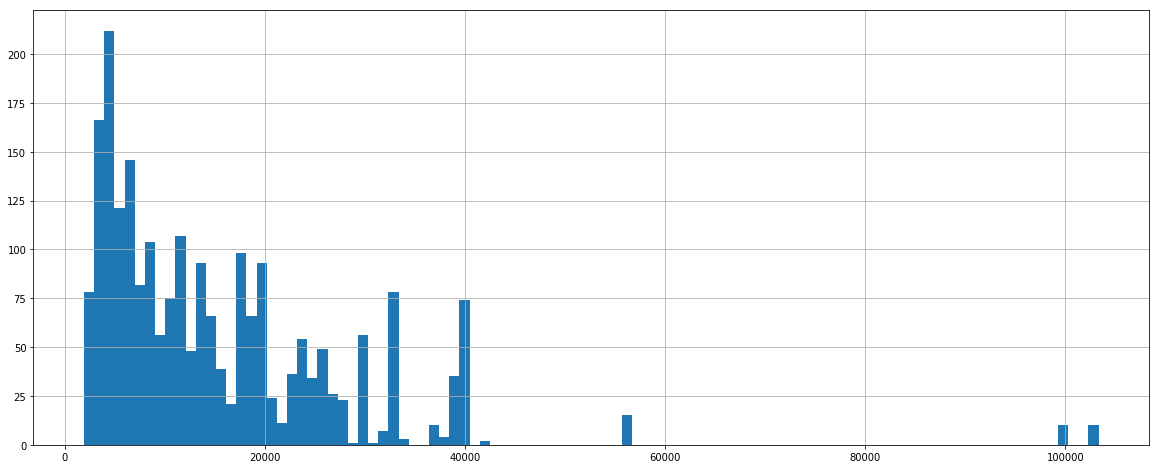

In [73]:
df_desc_linhas.range.hist(bins=100,figsize=(20,8))

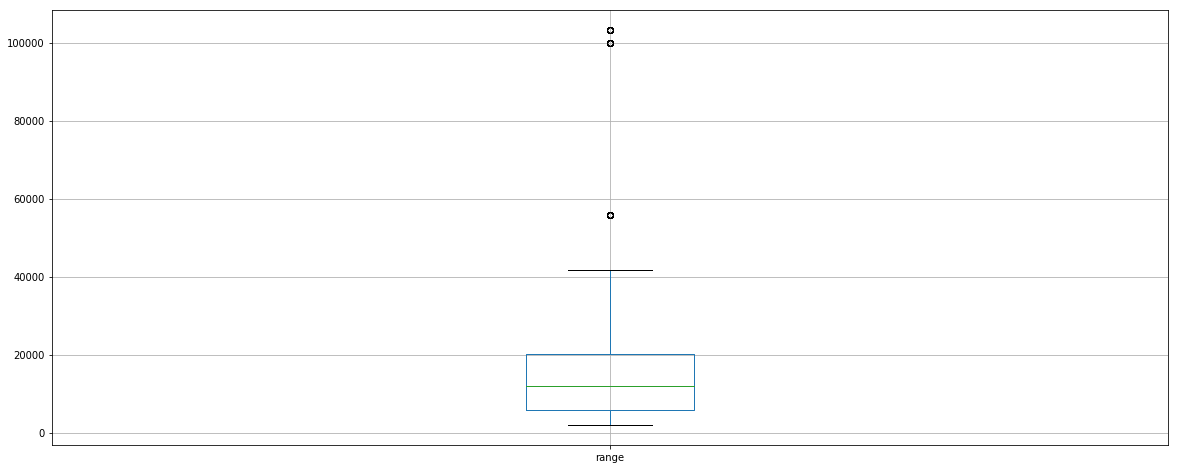

In [74]:
df_desc_linhas[['range']].boxplot(figsize=(20,8))

In [80]:
df_desc_linhas.range.describe()

count      2234.000000
mean      15501.102484
std       13577.165521
min        1948.080000
25%        5738.065000
50%       11947.800000
75%       20283.210000
max      103318.750000
Name: range, dtype: float64